# **EfficientNet**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install efficientnet_pytorch

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from efficientnet_pytorch import EfficientNet
from google.colab import drive
import torch.nn.functional as F
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import pandas as pd
from collections import Counter

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
dataset_dir = '/content/drive/MyDrive/Comys_Hackathon5/Task_A'

Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
class_names = train_dataset.classes

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

In [ ]:
class EfficientNetB4Classifier(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetB4Classifier, self).__init__()
        self.effnet = EfficientNet.from_pretrained('efficientnet-b4')
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1792, num_classes)
        )

    def forward(self, x):
        x = self.effnet.extract_features(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)
        return self.classifier(x)

In [ ]:
model = EfficientNetB4Classifier(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scaler = GradScaler()

Loaded pretrained weights for efficientnet-b4


/tmp/ipython-input-8-1741004412.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
num_epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
early_stop_counter = 0
PATIENCE = 5

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    # Early stopping check
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        torch.save(model.state_dict(), "/content/drive/MyDrive/Breast Thermography/best_model.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

Epoch 1/30, Train Loss: 0.2292, Train Acc: 0.9071, Val Loss: 0.2559, Val Acc: 0.9242
Epoch 2/30, Train Loss: 0.1096, Train Acc: 0.9548, Val Loss: 0.2002, Val Acc: 0.9147
Epoch 3/30, Train Loss: 0.0857, Train Acc: 0.9688, Val Loss: 0.3502, Val Acc: 0.9028
Epoch 4/30, Train Loss: 0.0371, Train Acc: 0.9881, Val Loss: 0.2626, Val Acc: 0.9242
Epoch 5/30, Train Loss: 0.0307, Train Acc: 0.9886, Val Loss: 0.2934, Val Acc: 0.9171
Epoch 6/30, Train Loss: 0.0176, Train Acc: 0.9953, Val Loss: 0.2877, Val Acc: 0.9360
Epoch 7/30, Train Loss: 0.0057, Train Acc: 0.9990, Val Loss: 0.3188, Val Acc: 0.9384
Early stopping triggered.


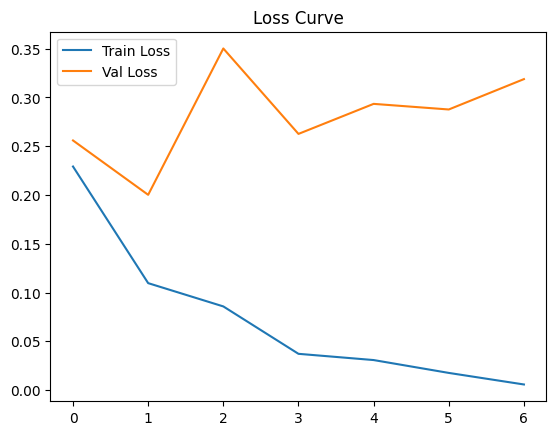

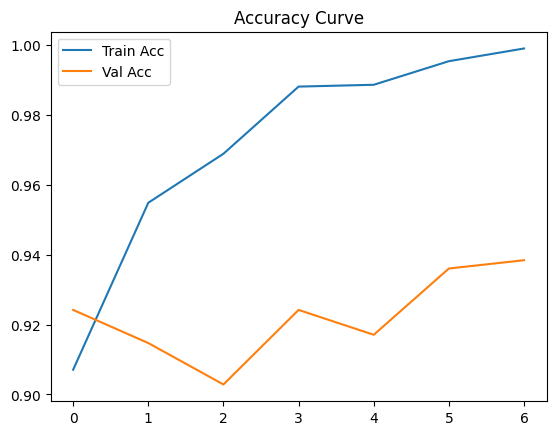

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title("Accuracy Curve")
plt.legend()
plt.show()

Classification Report:
              precision    recall  f1-score   support

      female       0.80      0.71      0.75        79
        male       0.93      0.96      0.95       343

    accuracy                           0.91       422
   macro avg       0.87      0.83      0.85       422
weighted avg       0.91      0.91      0.91       422



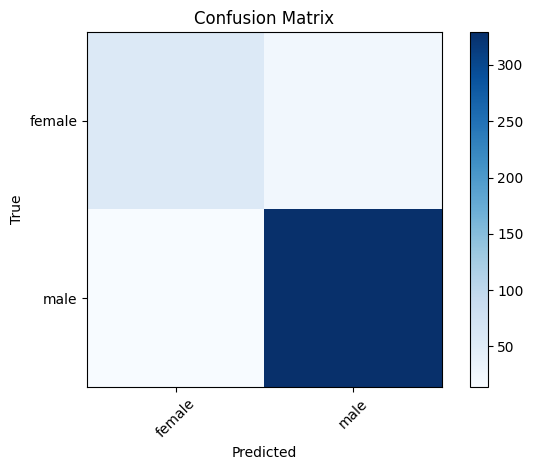

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Breast Thermography/best_model.pth"))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [ ]:
pred_df = pd.DataFrame({
    "true": [class_names[i] for i in all_labels],
    "pred": [class_names[i] for i in all_preds]
})
pred_df.to_csv("/content/drive/MyDrive/Comys_Hackathon5/Task_A/val_predictions.csv", index=False)
print("Saved predictions to CSV.")

Saved predictions to CSV.


In [ ]:
acc = accuracy_score(all_labels, all_preds)
print(f"Final Validation Accuracy: {acc*100:.2f}%")

Final Validation Accuracy: 91.23%


In [ ]:
transform = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
train_dataset = datasets.ImageFolder(root=os.path.join(dataset_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(dataset_dir, 'val'), transform=transform)
class_names = train_dataset.classes

In [ ]:
class_counts = Counter([label for _, label in train_dataset])
total_samples = sum(class_counts.values())
class_weights = [total_samples / class_counts[i] for i in range(len(class_names))]
sample_weights = [class_weights[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
class EfficientNetB4Classifier(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetB4Classifier, self).__init__()
        self.effnet = EfficientNet.from_pretrained('efficientnet-b4')
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1792, num_classes)
        )

    def forward(self, x):
        x = self.effnet.extract_features(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)
        return self.classifier(x)


In [ ]:
model = EfficientNetB4Classifier(num_classes=len(class_names)).to(device)

Loaded pretrained weights for efficientnet-b4


In [ ]:
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scaler = GradScaler()

In [ ]:
num_epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
early_stop_counter = 0
PATIENCE = 5

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    # Early stopping check
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        torch.save(model.state_dict(), "/content/drive/MyDrive/Comys_Hackathon5/Task_A/best_model.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

Epoch 1/30, Train Loss: 0.1137, Train Acc: 0.9268, Val Loss: 0.3998, Val Acc: 0.8697
Epoch 2/30, Train Loss: 0.1045, Train Acc: 0.9626, Val Loss: 0.2680, Val Acc: 0.9313
Epoch 3/30, Train Loss: 0.0575, Train Acc: 0.9621, Val Loss: 0.2492, Val Acc: 0.9336
Epoch 4/30, Train Loss: 0.0365, Train Acc: 0.9803, Val Loss: 0.2518, Val Acc: 0.9171
Epoch 5/30, Train Loss: 0.0281, Train Acc: 0.9798, Val Loss: 0.2456, Val Acc: 0.9360
Epoch 6/30, Train Loss: 0.0214, Train Acc: 0.9927, Val Loss: 0.2387, Val Acc: 0.9218
Epoch 7/30, Train Loss: 0.0168, Train Acc: 0.9943, Val Loss: 0.2402, Val Acc: 0.9313
Epoch 8/30, Train Loss: 0.0128, Train Acc: 0.9927, Val Loss: 0.2490, Val Acc: 0.9194
Epoch 9/30, Train Loss: 0.0125, Train Acc: 0.9943, Val Loss: 0.2078, Val Acc: 0.9289
Epoch 10/30, Train Loss: 0.0062, Train Acc: 0.9958, Val Loss: 0.2041, Val Acc: 0.9265
Epoch 11/30, Train Loss: 0.0099, Train Acc: 0.9938, Val Loss: 0.2380, Val Acc: 0.9147
Epoch 12/30, Train Loss: 0.0047, Train Acc: 0.9974, Val Loss: 0

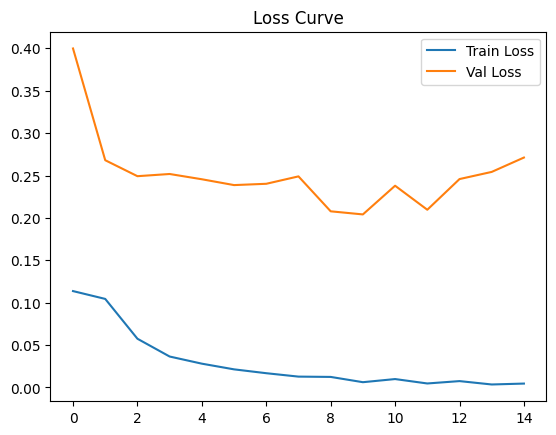

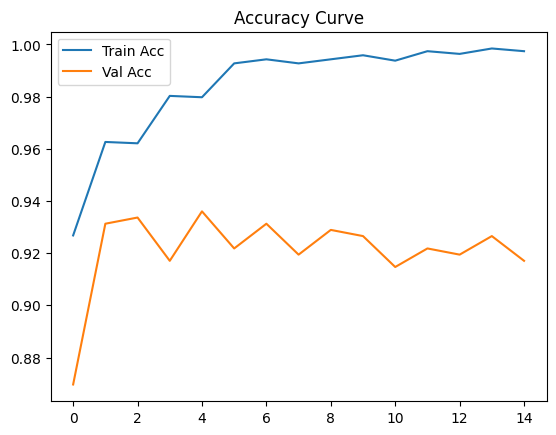

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title("Accuracy Curve")
plt.legend()
plt.show()


Classification Report:
              precision    recall  f1-score   support

      female       0.82      0.81      0.82        79
        male       0.96      0.96      0.96       343

    accuracy                           0.93       422
   macro avg       0.89      0.88      0.89       422
weighted avg       0.93      0.93      0.93       422



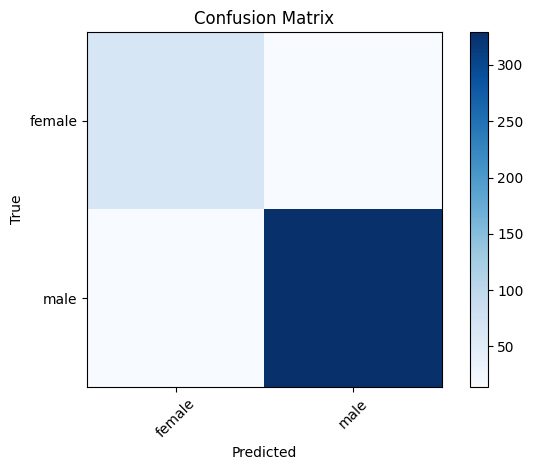

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Comys_Hackathon5/Task_A/best_model.pth"))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [ ]:
pred_df = pd.DataFrame({
    "true": [class_names[i] for i in all_labels],
    "pred": [class_names[i] for i in all_preds]
})
pred_df.to_csv("/content/drive/MyDrive/Comys_Hackathon5/Task_A/val_predictions.csv", index=False)
print("Saved predictions to CSV.")

Saved predictions to CSV.


In [ ]:
acc = accuracy_score(all_labels, all_preds)
print(f"Final Validation Accuracy: {acc*100:.2f}%")


Final Validation Accuracy: 93.13%


# **ViT**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from transformers import ViTForImageClassification, ViTFeatureExtractor
from google.colab import drive
from collections import Counter
from torch.cuda.amp import GradScaler, autocast
import pandas as pd

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

def transform_fn(image):
    return feature_extractor(images=image, return_tensors="pt")['pixel_values'][0]

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = datasets.ImageFolder(root=os.path.join(dataset_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(dataset_dir, 'val'), transform=transform)
class_names = train_dataset.classes


In [ ]:
class_counts = Counter([label for _, label in train_dataset])
total_samples = sum(class_counts.values())
class_weights = [total_samples / class_counts[i] for i in range(len(class_names))]
sample_weights = [class_weights[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(class_names)
).to(device)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scaler = GradScaler()

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
num_epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
early_stop_counter = 0
PATIENCE = 5

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images).logits
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / total)

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs = model(images).logits
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        torch.save(model.state_dict(), "/content/drive/MyDrive/Comys_Hackathon5/Task_A/best_model_ViT.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

Epoch 1/30, Train Loss: 0.0470, Train Acc: 0.9746, Val Loss: 0.2443, Val Acc: 0.9123
Epoch 2/30, Train Loss: 0.0232, Train Acc: 0.9860, Val Loss: 0.2585, Val Acc: 0.9265
Epoch 3/30, Train Loss: 0.0131, Train Acc: 0.9938, Val Loss: 0.2852, Val Acc: 0.9242
Epoch 4/30, Train Loss: 0.0105, Train Acc: 0.9948, Val Loss: 0.3132, Val Acc: 0.9218
Epoch 5/30, Train Loss: 0.0131, Train Acc: 0.9927, Val Loss: 0.3132, Val Acc: 0.9218
Epoch 6/30, Train Loss: 0.0108, Train Acc: 0.9958, Val Loss: 0.3152, Val Acc: 0.9218
Early stopping triggered.


Classification Report:
              precision    recall  f1-score   support

      female       0.73      0.84      0.78        79
        male       0.96      0.93      0.94       343

    accuracy                           0.91       422
   macro avg       0.84      0.88      0.86       422
weighted avg       0.92      0.91      0.91       422



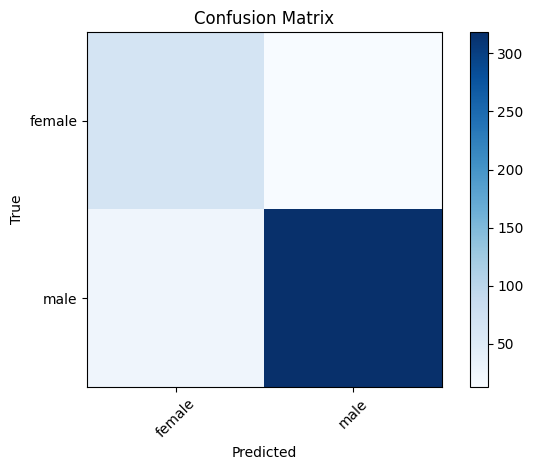

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Comys_Hackathon5/Task_A/best_model_vit.pth"))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images).logits
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [ ]:
image_paths = [s[0] for s in val_dataset.samples]
pred_df = pd.DataFrame({
    "image_path": image_paths,
    "true": [class_names[i] for i in all_labels],
    "pred": [class_names[i] for i in all_preds]
})
pred_df.to_csv("/content/drive/MyDrive/Comys_Hackathon5/Task_A/vit_val_predictions.csv", index=False)
print("Saved predictions to CSV.")

acc = accuracy_score(all_labels, all_preds)
print(f"Final Validation Accuracy: {acc*100:.2f}%")

Saved predictions to CSV.
Final Validation Accuracy: 91.00%


In [ ]:
def apply_tta(model, dataset):
    tta_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    tta_loader = DataLoader(datasets.ImageFolder(root=os.path.join(dataset_dir, 'val'), transform=tta_transform), batch_size=32, shuffle=False)
    model.eval()
    all_preds = []
    with torch.no_grad():
        for images, _ in tta_loader:
            images = images.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
    return all_preds


# **Eff**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from collections import Counter
from torch.cuda.amp import GradScaler, autocast
import pandas as pd

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [ ]:
train_dataset = datasets.ImageFolder(root=os.path.join(dataset_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(dataset_dir, 'val'), transform=transform)
class_names = train_dataset.classes

In [ ]:
class_counts = Counter([label for _, label in train_dataset])
total_samples = sum(class_counts.values())
class_weights = [total_samples / class_counts[i] for i in range(len(class_names))]
sample_weights = [class_weights[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
model = models.efficientnet_b0(pretrained=True)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, len(class_names))
model = model.to(device)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scaler = GradScaler()

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 82.9MB/s]


In [ ]:
num_epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
early_stop_counter = 0
PATIENCE = 5

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / total)

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        torch.save(model.state_dict(), "/content/drive/MyDrive/Comys_Hackathon5/Task_A/best_model_efficientnet.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

Epoch 1/30, Train Loss: 0.1767, Train Acc: 0.8718, Val Loss: 0.4114, Val Acc: 0.8768
Epoch 2/30, Train Loss: 0.0544, Train Acc: 0.9637, Val Loss: 0.2499, Val Acc: 0.9123
Epoch 3/30, Train Loss: 0.0340, Train Acc: 0.9766, Val Loss: 0.3009, Val Acc: 0.9100
Epoch 4/30, Train Loss: 0.0369, Train Acc: 0.9787, Val Loss: 0.2402, Val Acc: 0.9147
Epoch 5/30, Train Loss: 0.0277, Train Acc: 0.9808, Val Loss: 0.2866, Val Acc: 0.9242
Epoch 6/30, Train Loss: 0.0209, Train Acc: 0.9881, Val Loss: 0.2805, Val Acc: 0.9242
Epoch 7/30, Train Loss: 0.0134, Train Acc: 0.9912, Val Loss: 0.2848, Val Acc: 0.9147
Epoch 8/30, Train Loss: 0.0085, Train Acc: 0.9953, Val Loss: 0.2760, Val Acc: 0.9171
Epoch 9/30, Train Loss: 0.0118, Train Acc: 0.9933, Val Loss: 0.2723, Val Acc: 0.9218
Early stopping triggered.


Classification Report:
              precision    recall  f1-score   support

      female       0.76      0.77      0.77        79
        male       0.95      0.94      0.95       343

    accuracy                           0.91       422
   macro avg       0.85      0.86      0.86       422
weighted avg       0.91      0.91      0.91       422



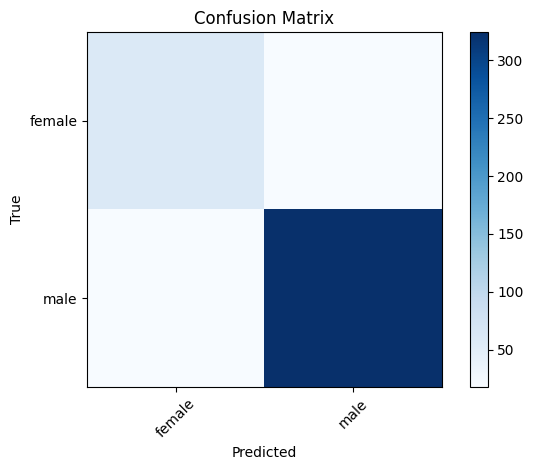

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Comys_Hackathon5/Task_A/best_model_efficientnet.pth"))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [ ]:
image_paths = [s[0] for s in val_dataset.samples]
pred_df = pd.DataFrame({
    "image_path": image_paths,
    "true": [class_names[i] for i in all_labels],
    "pred": [class_names[i] for i in all_preds]
})
pred_df.to_csv("/content/drive/MyDrive/Comys_Hackathon5/Task_A/efficientnet_val_predictions.csv", index=False)
print("Saved predictions to CSV.")

acc = accuracy_score(all_labels, all_preds)
print(f"Final Validation Accuracy: {acc*100:.2f}%")

Saved predictions to CSV.
Final Validation Accuracy: 91.23%


In [ ]:
def apply_tta(model, dataset):
    tta_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    tta_loader = DataLoader(datasets.ImageFolder(root=os.path.join(dataset_dir, 'val'), transform=tta_transform), batch_size=32, shuffle=False)
    model.eval()
    all_preds = []
    with torch.no_grad():
        for images, _ in tta_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
    return all_preds